In [1]:
import scipy.io as sio
from scipy.fft import fft
import os,glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mat4py import loadmat

In [2]:
import scipy.io as sio
from mat4py import loadmat
import numpy as np

def wfft_hz(filename, Hz_Lthr, Hz_Hthr):
    '"Lthr: lower threshold; Hthr: high threshold"'
    data = loadmat(filename)
    fft_data = fft(data['data'])
    NFFT = math.floor(len(data['data'])/2)+1
    fft_data = abs(fft_data[1:NFFT])
    f = data['Fs']/2 * np.linspace(0, 1, NFFT)
    idx = [i for i, e in enumerate(f) if e>= Hz_Lthr and e <= Hz_Hthr ] 
    X=f[idx]
    y=fft_data[idx]
    return X, y

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def remove_trends_from_signal(X, y):
    Y = [ round(item, 6) for elem in y for item in elem ]
    m, b = np.polyfit(X, y, 1)
    Y = Y-(m*X)
    return Y

def find_top_peaks_with_guasian_weight(file, Hz_Lthr, Hz_Hthr, mu, sigma, number_of_peak):
    [X, y] =  wfft_hz(file,Hz_Lthr, Hz_Hthr)
    Y = remove_trends_from_signal(X,y)
    peaks, _ = find_peaks(Y, height=0)
    gaussoan_weight=gaussian(np.array(X), mu, sigma)
    y_with_weight = Y*gaussoan_weight
    top_peaks = heapq.nlargest(number_of_peak, y_with_weight[peaks])
    top_peaks_idx = [index[0] for index in [np.where(y_with_weight == peak)[0] for peak in top_peaks]]
    top_peaks_idx.sort()
    return X, Y, top_peaks_idx

def find_top_peaks_with_uniform_weight(file, Hz_Lthr, Hz_Hthr, ROI_Hz_Lthr, ROI_Hz_Hthr ,low_weight, high_weight, number_of_peak):
    [X, y] =  wfft_hz(file,Hz_Lthr, Hz_Hthr)
    Y = remove_trends_from_signal(X,y)
    peaks, _ = find_peaks(Y, height=0)
    uniform_weight=get_uniform_weight(X, ROI_Hz_Lthr, ROI_Hz_Hthr, low_weight, high_weight)
    y_with_weight = Y*uniform_weight
    top_peaks = heapq.nlargest(number_of_peak, y_with_weight[peaks])
    top_peaks_idx = [index[0] for index in [np.where(y_with_weight == peak)[0] for peak in top_peaks]]
    top_peaks_idx.sort()
    return X, Y, top_peaks_idx

def find_top_peaks_with_uniform_weight_v2(file, Hz_Lthr, Hz_Hthr, ROI_Hz_Lthr, ROI_Hz_Hthr ,low_weight,
                                          high_weight, high_weight2, number_of_peak):
    [X, y] =  wfft_hz(file,Hz_Lthr, Hz_Hthr)
    Y = remove_trends_from_signal(X,y)
    peaks, _ = find_peaks(Y, height=0)
    uniform_weight=get_uniform_weight_v2(X, ROI_Hz_Lthr, ROI_Hz_Hthr, low_weight, high_weight, high_weight2)
    y_with_weight = Y*uniform_weight
    top_peaks = heapq.nlargest(number_of_peak, y_with_weight[peaks])
    top_peaks_idx = [index[0] for index in [np.where(y_with_weight == peak)[0] for peak in top_peaks]]
    top_peaks_idx.sort()
    return X, Y, top_peaks_idx


def get_uniform_weight(X, Hz_Lthr, Hz_Hthr, low, high):
    result_l = list(filter(lambda x: x < Hz_Lthr, X))
    result_l = np.random.uniform(low, high, len(result_l))
    result_l = sorted(result_l)
    
    result_r = list(filter(lambda x: x > Hz_Hthr, X))
    result_r = np.random.uniform(low, high, len(result_r))
    result_r = sorted(result_r, reverse=True)
    
    uniform_weight = np.random.uniform(high, high, len(X))
    uniform_weight = [x for i, x in enumerate(uniform_weight) if X[i] >= Hz_Lthr and X[i] <= Hz_Hthr]
    
    uniform_weight.extend(result_r)
    result_l.extend(uniform_weight)
    return result_l

def get_uniform_weight_v2(X, Hz_Lthr, Hz_Hthr, low, high, high2):
    result_l = list(filter(lambda x: x < Hz_Lthr, X))
    result_l = np.random.uniform(low, high, len(result_l))
    result_l = sorted(result_l)
    
    result_r = list(filter(lambda x: x > Hz_Hthr, X))
    result_r = np.random.uniform(low, high, len(result_r))
    result_r = sorted(result_r, reverse=True)
    
    uniform_weight = np.random.uniform(high, high2, len(X))
    uniform_weight = sorted(uniform_weight, reverse=True)
    uniform_weight = [x for i, x in enumerate(uniform_weight) if X[i] >= Hz_Lthr and X[i] <= Hz_Hthr]
    
    uniform_weight.extend(result_r)
    result_l.extend(uniform_weight)
    return result_l
    

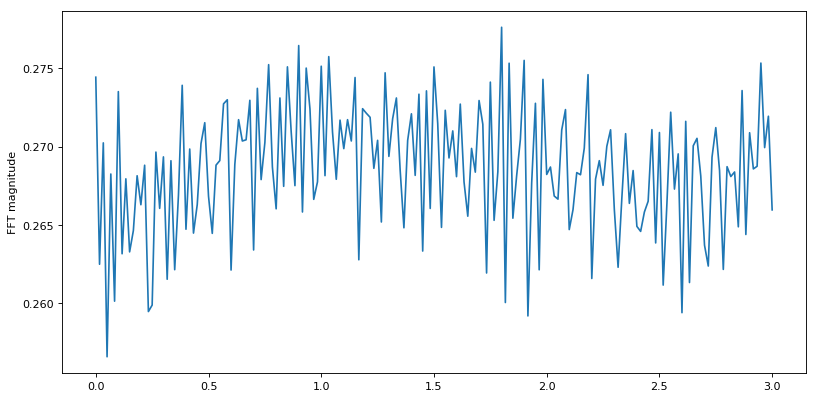

In [15]:
Hz_Lthr, Hz_Hthr =0.0, 3.0
#remove trends from data
file = '../datasets/Age_A/Age_A_Male/Sub 36/36Neck_R_A_1.mat'

[X,y] =  wfft_hz(file,Hz_Lthr, Hz_Hthr)
plt.figure(figsize=(12, 6), dpi=80)
Y = remove_trends_from_signal(X, y)
plt.plot(X, Y)
plt.ylabel('FFT magnitude')
plt.show()

In [16]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(Y, height=0)
len(peaks)

66